In [6]:
import wandb
import re

api = wandb.Api()

project = "rank_masking"
entity = "alismalahova31-uniwersytet-jagiello-ski-w-krakowie"

runs = api.runs(f"{entity}/{project}")

run_max_metrics = []

for run in runs:
    seed = run.config.get("seed", "N/A")
    if(seed!=0):
        run_history = run.history()
        rank_metrics = [key for key, value in run_history.items() if re.match(r"eval/rank_1[0-9]_matthews_correlation|eval/rank_2[0-5]_matthews_correlation", key)]
        if rank_metrics:
            max_metric_per_rank = {key: run.history(keys=[key])[key].max()*100 for key in sorted(rank_metrics, key=lambda item: int(re.search(r'\d+', item).group()))}
            overall_max = max(max_metric_per_rank.items(), key=lambda item: item[1])
            run_max_metrics.append({
                "run_name": run.name,
                "seed": seed,
                "max_per_rank": max_metric_per_rank,
                "overall_max": overall_max
            })

for result in run_max_metrics:
    print(f"Run Name: {result['run_name']}, Seed: {result['seed']}")
    print(f"Max per rank:")
    for rank, value in result['max_per_rank'].items():
        print(f"  {rank}: {value}")
    print(f"Overall Max: {result['overall_max']}\n")


Run Name: rank_masking_results_cola_25, Seed: 0
Max per rank:
  eval/rank_10_matthews_correlation: 62.69342965374732
  eval/rank_11_matthews_correlation: 62.39432836092743
  eval/rank_12_matthews_correlation: 62.49925495853809
  eval/rank_13_matthews_correlation: 62.71181330277995
  eval/rank_14_matthews_correlation: 64.55219823779294
  eval/rank_15_matthews_correlation: 65.14369114610611
  eval/rank_16_matthews_correlation: 65.45855021006344
  eval/rank_17_matthews_correlation: 66.50186553771599
  eval/rank_18_matthews_correlation: 66.60525699826668
  eval/rank_19_matthews_correlation: 65.74528239214806
  eval/rank_20_matthews_correlation: 66.70852438908148
  eval/rank_21_matthews_correlation: 67.82375592686908
  eval/rank_22_matthews_correlation: 67.99299742952391
  eval/rank_23_matthews_correlation: 66.08394117851918
  eval/rank_24_matthews_correlation: 66.51235958599987
  eval/rank_25_matthews_correlation: 66.40626014130119
Overall Max: ('eval/rank_22_matthews_correlation', 67.9929

In [3]:
import numpy as np
max_per_rank_values = {rank: [] for rank in run_max_metrics[0]['max_per_rank'].keys()}
overall_max_values = []

for result in run_max_metrics:
    for rank, value in result['max_per_rank'].items():
        max_per_rank_values[rank].append(value )  
    overall_max_values.append(result['overall_max'][1])  

max_per_rank_stats = {rank: {"median": np.median(values), "std": np.std(values)} for rank, values in max_per_rank_values.items()}

overall_max_median = np.median(overall_max_values)
overall_max_std = np.std(overall_max_values)

print("Max per Rank Metrics:")
for rank, stats in max_per_rank_stats.items():
    print(f"{rank}: {stats['median']:.2f} ± {stats['std']:.2f}")

print(f"\nOverall Max: {overall_max_median:.2f} ± {overall_max_std:.2f}")


Max per Rank Metrics:
eval/rank_10_matthews_correlation: 62.23 ± 0.73
eval/rank_11_matthews_correlation: 63.77 ± 0.53
eval/rank_12_matthews_correlation: 63.94 ± 0.35
eval/rank_13_matthews_correlation: 64.74 ± 0.84
eval/rank_14_matthews_correlation: 66.03 ± 0.77
eval/rank_15_matthews_correlation: 66.48 ± 0.64
eval/rank_16_matthews_correlation: 66.64 ± 0.45
eval/rank_17_matthews_correlation: 66.79 ± 0.79
eval/rank_18_matthews_correlation: 67.41 ± 0.26
eval/rank_19_matthews_correlation: 67.35 ± 0.39
eval/rank_20_matthews_correlation: 67.01 ± 0.45
eval/rank_21_matthews_correlation: 67.44 ± 1.02
eval/rank_22_matthews_correlation: 67.46 ± 0.53
eval/rank_23_matthews_correlation: 67.49 ± 0.43
eval/rank_24_matthews_correlation: 66.52 ± 0.31
eval/rank_25_matthews_correlation: 66.90 ± 0.74

Overall Max: 68.32 ± 0.60


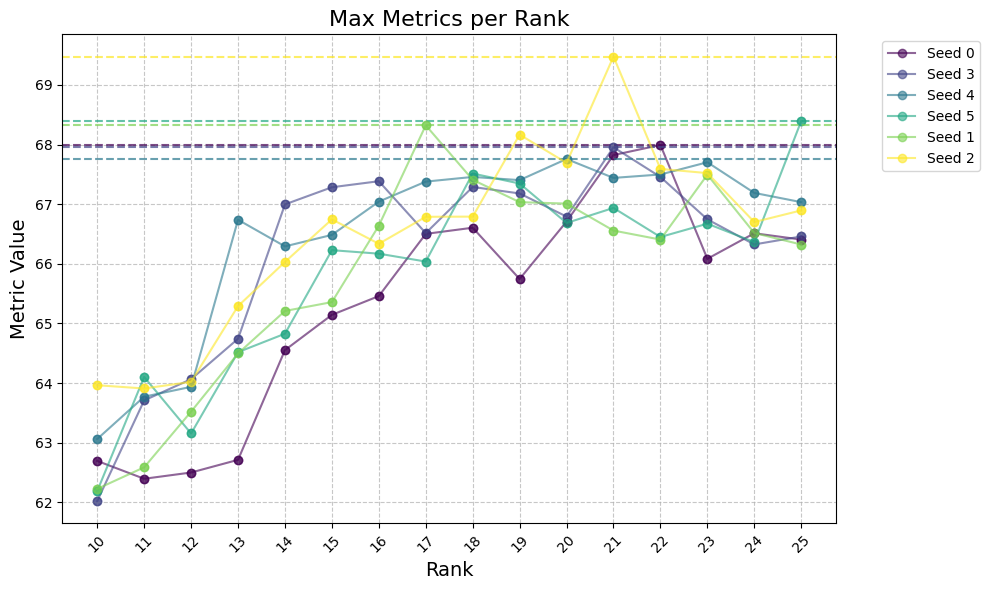

In [25]:
import matplotlib.pyplot as plt
import matplotlib.cm as cm
all_ranks = set()
for result in run_max_metrics:
    all_ranks.update(result["max_per_rank"].keys())

rank_labels = sorted([int(rank.split("_")[1]) for rank in all_ranks])
colors = cm.viridis(np.linspace(0, 1, len(rank_labels)))
rank_color_map = {rank: color for rank, color in zip(rank_labels, colors)}

fig, ax = plt.subplots(figsize=(10, 6))

for result in run_max_metrics:
    seed = result["seed"]
    max_per_rank = result["max_per_rank"]
    overall_max = result["overall_max"][1]
    
    x_values = [int(rank.split("_")[1]) for rank in max_per_rank.keys()]
    y_values = list(max_per_rank.values())
    
    run_color = cm.viridis(np.linspace(0, 1, len(run_max_metrics)))[run_max_metrics.index(result)]

    for x, y in zip(x_values, y_values):
        ax.scatter(x, y, color=run_color, alpha=0.6)  
    
    ax.plot(
        x_values,
        y_values,
        marker="o",
        label=f"Seed {seed}",  
        color=run_color,  
        alpha=0.6,
    )
    
    ax.axhline(y=overall_max, color=run_color, linestyle='--', alpha=0.7, label='Overall max')

ax.set_title("Max Metrics per Rank", fontsize=16)
ax.set_xlabel("Rank", fontsize=14)
ax.set_ylabel("Metric Value", fontsize=14)

ax.set_xticks(rank_labels)
ax.set_xticklabels(rank_labels)

handles, labels = ax.get_legend_handles_labels()
handles, labels = zip(*[(h, l) for h, l in zip(handles, labels) if "Seed" in l])
ax.legend(handles, labels, bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=10)

plt.xticks(rotation=45)
plt.tight_layout()
plt.grid(True, linestyle='--', alpha=0.7)
plt.show()

In [26]:
wandb.init(project=project, entity=entity, name="Max Metrics Plot Report")
plot_filename = "max_metrics_per_rank.png"
plt.savefig(plot_filename)

# Log the plot to WandB
wandb.log({"Max Metrics per Rank Plot": wandb.Image(plot_filename)})

# Optionally, show the plot
plt.show()

# Finish the WandB run
wandb.finish()

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: alismalahova31 (alismalahova31-uniwersytet-jagiello-ski-w-krakowie). Use `wandb login --relogin` to force relogin


<Figure size 640x480 with 0 Axes>

In [ ]:
cola_mcc_dict = {
    "eval/mcc_4": 60.52,   # 1.5K
    "eval/mcc_8": 64.39,   # 6.1K
    "eval/mcc_12": 65.47,  # 13.8K
    "eval/mcc_16": 66.96,  # 24.6K
    "eval/mcc_20": 68.08,  # 38.4K
    "eval/mcc_25": 68.55
}